In [1]:
import imageio as iio
import numpy as np

In [3]:
fileName = "./Images/kodim23.qoi"

with open(fileName , "rb") as f:
    fileContent = f.read()
    f.close()

In [16]:
def get_qoi_hash(pixel):
    # (r * 3 + g * 5 + b * 7 + a * 11) % 64
    # (r * 3 + g * 5 + b * 7 + a * 11)  & 0b00111111
    gg = pixel.astype(np.int16)
    return ( (gg[0]*3) +  (gg[1]*5) +(gg[2]*7) + (255*11)) %64 # alpha is 255 if not availabel

In [17]:
MAGIC = [chr(fileContent[0]), chr(fileContent[1]), chr(fileContent[2]), chr(fileContent[3])]
WIDTH = (fileContent[4]<<24 ) | (fileContent[5] << 16) |  (fileContent[6] << 8 ) | (fileContent[7])
HEIGHT = (fileContent[8]<<24 ) | (fileContent[9] << 16) |  (fileContent[10] << 8 ) | (fileContent[11])
CHANNEL = fileContent[12]
COLORSPACE = fileContent[13]

print(MAGIC, WIDTH, HEIGHT, CHANNEL, COLORSPACE)

['q', 'o', 'i', 'f'] 768 512 3 0


In [23]:
QOI_OP_RGB = 0b11111110
QOI_OP_INDEX = 0b00
QOI_OP_DIFF = 0b01
QOI_OP_LUMA = 0b10
QOI_OP_RUN = 0b11

INDEX_LIST = [None for i in range(64)]
imgDecoded = np.zeros((HEIGHT*WIDTH,3), dtype=np.uint8)


indx = 0
i = 14
currPix = np.zeros((3,))
while i < (len(fileContent) - 8):
    currentVal = fileContent[i]

    if currentVal == QOI_OP_RGB: 
        R = fileContent[i+1]
        G = fileContent[i+2]
        B = fileContent[i+3]
        i = i + 3

        currPix = np.asarray([R, G, B])
        imgDecoded[indx] = currPix
        indx = indx + 1
    elif currentVal>>6  == QOI_OP_INDEX: # for this condition to occur, the value would have been in the INDEX alread due to previous values
        indexcurrentVal = currentVal & 0b00111111

        currPix = np.asarray([R, G, B])
        imgDecoded[indx] = currPix
        indx = indx + 1
    elif currentVal>>6  == QOI_OP_DIFF:
        diff = np.asarray([(currentVal>>4) & 0b11 , (currentVal>>2) & 0b11, (currentVal>>0) & 0b11])
        diff = diff - 2 # removing biasing
        # here currPix would contain the preivous peixel
        newPixel = currPix + diff

        currPix = newPixel
        imgDecoded[indx] = currPix
        indx = indx + 1
    elif currentVal>>6 == QOI_OP_LUMA:
        diffG = fileContent[i] & 0b00111111
        i = i + 1
        diffG = diffG - 32
        dr_dg = (fileContent[i+1] >> 4) & 0b1111
        dr_dg = dr_dg - 8
        db_dg = (fileContent[i+1] >> 0) & 0b1111
        db_dg = db_dg - 8
        diffR = dr_dg + diffG
        diffB = db_dg + diffG 


        diff = np.asarray([diffR, diffG, diffB])

        # here currPix would contain the preivous peixel
        newPixel = currPix + diff

        currPix = newPixel
        imgDecoded[indx] = currPix
        indx = indx + 1
    elif currentVal>>6  == QOI_OP_RUN:
        run = currentVal & 0b001111111
        # now currentPix should be repeadted till run becomes zeros
        print(currentVal, run)
        while (run>0):
            imgDecoded[indx] = currPix
            indx = indx + 1
            run = run - 1

    # adding to the INDEX
    hashIndex = get_qoi_hash(currPix)
    INDEX_LIST[hashIndex] = currPix

    i = i + 1


192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
193 65
192 64
192 64
192 64
193 65
194 66
192 64
192 64
192 64
192 64
192 64
192 64
193 65
192 64
194 66
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
193 65
192 64
192 64
193 65
193 65
193 65
192 64
193 65
192 64
193 65
192 64
193 65
192 64
192 64
192 64
192 64
192 64
192 64
192 64
193 65
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
194 66
194 66
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
192 64
194 66
192 64
194 66
192 64
192 64
192 64
192 64
192 64
192 64
192 64
194 66
192 64
193 65
192 64
192 64
193 65
192 64
192 64
192 64
193 65
192 64
194 66
193 65
193 65
192 64
193 65
193 65
192 64
192 64
193 65
192 64
192 64
193 65
192 64
193 65
192 64
192 64
192 64
195 67
192 64
192 64
192 64
192 64
193 65
192 64
193 65
193 65
192 64

IndexError: index 393216 is out of bounds for axis 0 with size 393216

In [12]:
print(imgDecoded[:10])

[[116 116  88]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]]


In [15]:
 len(fileContent)

675251

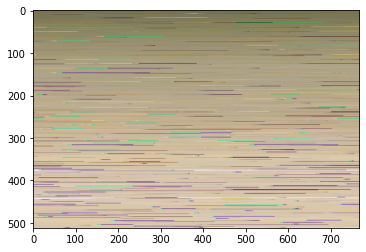

In [26]:
from matplotlib import pyplot as plt
igg = imgDecoded.reshape(HEIGHT, , 3)
plt.imshow(igg)
plt.show()

In [27]:
igg

array([[[116, 116,  88],
        [117, 117,  89],
        [117, 120,  85],
        ...,
        [116, 116,  88],
        [116, 116,  88],
        [116, 116,  88]],

       [[116, 116,  88],
        [116, 116,  88],
        [116, 116,  88],
        ...,
        [122, 111,  76],
        [122, 111,  76],
        [122, 111,  76]],

       [[122, 111,  76],
        [122, 111,  76],
        [122, 111,  76],
        ...,
        [116, 116,  88],
        [116, 116,  88],
        [116, 116,  88]],

       ...,

       [[216, 200, 178],
        [216, 200, 178],
        [216, 200, 178],
        ...,
        [216, 200, 178],
        [216, 200, 178],
        [216, 200, 178]],

       [[216, 200, 178],
        [216, 200, 178],
        [216, 200, 178],
        ...,
        [220, 199, 170],
        [220, 199, 170],
        [220, 199, 170]],

       [[220, 199, 170],
        [220, 199, 170],
        [220, 199, 170],
        ...,
        [247, 242, 254],
        [247, 242, 254],
        [247, 242, 254]]